# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input.

## System: driven damped pendulum

Consider a single pendulum with angle $\theta(t)$ and input $u(t)$ evolving according to:

$$ \ddot{\theta} + \frac{\mathcal{g}}{l} \sin(\theta) + \frac{\gamma}{l} \dot{\theta} = \frac{1}{ml} u\, .$$

where $m$ is mass, $l$ is length, $\gamma$ is damping and $\mathcal{g}$ is Earth's gravity.

In [79]:
using Revise
using ForwardDiff
using Optim
using RxInfer
using SpecialFunctions
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3,margin=20Plots.pt)

includet("./NARXAgents.jl"); using .NARXAgents
includet("./Pendulums.jl"); using .Pendulums

In [80]:
# System parameters
sys_mass = 2.0
sys_length = 0.5
sys_damping = 0.2
sys_mnoise_sd = 1e-3
sys_ulims = (-50.,50.)
Δt = 0.1

init_state = [0.0, 0.0]
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

SPendulum([0.0, 0.0], -0.0014446307828144531, 0.0, (-50.0, 50.0), 0.1, 2.0, 0.5, 0.2, 0.001)

In [81]:
N = 300
tsteps = range(0.0, step=Δt, length=N)

0.0:0.1:29.9

In [82]:
# Inputs
A  = rand(10)*200 .- 100
Ω  = rand(10)*3
controls = mean([A[i]*sin.(Ω[i].*tsteps) for i = 1:10]) ./ 10;

In [83]:
states = zeros(2,N)
observations = zeros(N)
torques = zeros(N)

for k in 1:N
    states[:,k] = pendulum.state
    observations[k] = pendulum.sensor
    step!(pendulum, controls[k])
    torques[k] = pendulum.torque
end

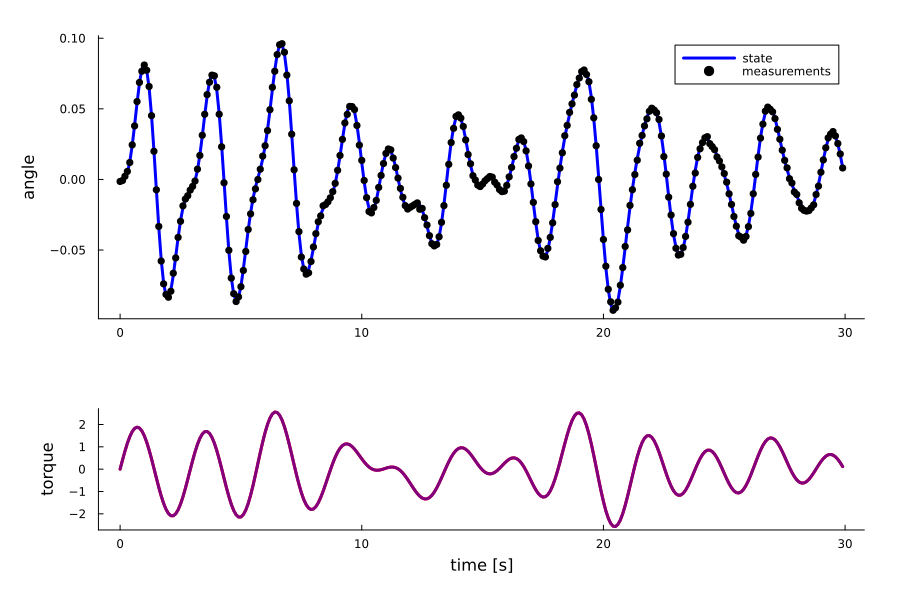

In [84]:
p1 = plot(ylabel="angle")
plot!(tsteps, states[1,:], color="blue", label="state")
scatter!(tsteps, observations, color="black", label="measurements")
p2 = plot(xlabel="time [s]", ylabel="torque")
plot!(tsteps, controls[:], color="red")
plot!(tsteps, torques[:], color="purple")
plot(p1,p2, layout=grid(2,1, heights=[0.7, 0.3]), size=(900,600))

## Test model

In [85]:
# NARX settings
H = 1
Ly = 3
Lu = 3
M = size(ϕ(zeros(Ly+Lu), degree=H),1);

# Specify prior distributions
pτ0 = GammaShapeRate(1e3, 1e0)
pθ0 = MvNormalMeanCovariance(zeros(M), 10diagm(ones(M)))
goal = NormalMeanVariance(3.14, 1e-3)

T = 15
u_prior = 0.0
num_iters = 5

agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  thorizon=T,
                  control_prior=control_prior,
                  num_iters=num_iters)

NARXAgent(FactorGraphModel(), Constraints:
  marginals form:
  messages form:
  factorisation:
    q(θ, τ) = q(θ)q(τ)
Options:
  warn = true
, [Inf], MvNormalMeanCovariance(
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [10.0 0.0 … 0.0 0.0; 0.0 10.0 … 0.0 0.0; … ; 0.0 0.0 … 10.0 0.0; 0.0 0.0 … 0.0 10.0]
)
, GammaShapeRate{Float64}(a=1000.0, b=1.0), NormalMeanVariance{Float64}(μ=3.14, v=0.001), 15, 5, 0.0, 3, 3, 1, 7, [0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

In [86]:
py = []
qθ = [pθ0]
qτ = [pτ0]
FE = zeros(num_iters,N)

pp = Progress(N-T; showspeed=true)
for k in 1:(N-T)
    
    # Make predictions
    push!(py, predictions(agent, torques[k:k+T], time_horizon=T))
    
    # Update beliefs
    NARXAgents.update!(agent, observations[k], torques[k])
    push!(qθ, agent.qθ)
    push!(qτ, agent.qτ)
    
    # Evaluate
    FE[:,k] = agent.free_energy

    ProgressMeter.next!(pp)
end

Progress:  42%|███████████▍               |  ETA: 0:00:00 ( 0.84 ms/it)

Progress:  90%|████████████████████████▎  |  ETA: 0:00:00 ( 0.78 ms/it)

Progress: 100%|███████████████████████████| Time: 0:00:00 ( 0.77 ms/it)


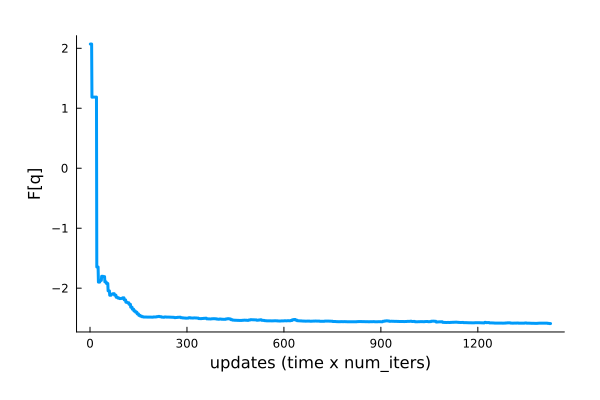

In [87]:
plot(reshape(FE[:,1:(N-T)], (num_iters*(N-T),)), xlabel="updates (time x num_iters)", ylabel="F[q]")

In [88]:
vθ = cat( var.(qθ)...,dims=2)
mθ = cat(mean.(qθ)...,dims=2)

7×286 Matrix{Float64}:
 0.0  -0.00144449  -0.00144409  -0.00144541  …  -1.36399e-5   -1.13862e-5
 0.0   0.0         -5.6987e-6    2.26598e-5      1.1179        1.11845
 0.0   0.0          0.0         -2.00471e-5      0.199219      0.198174
 0.0   0.0          0.0          0.0            -0.636696     -0.636052
 0.0   0.0          0.00162645   0.00163631      0.00123308    0.00128975
 0.0   0.0          0.0          0.00572161  …  -0.000283021  -0.000388072
 0.0   0.0          0.0          0.0             0.00724688    0.00729308

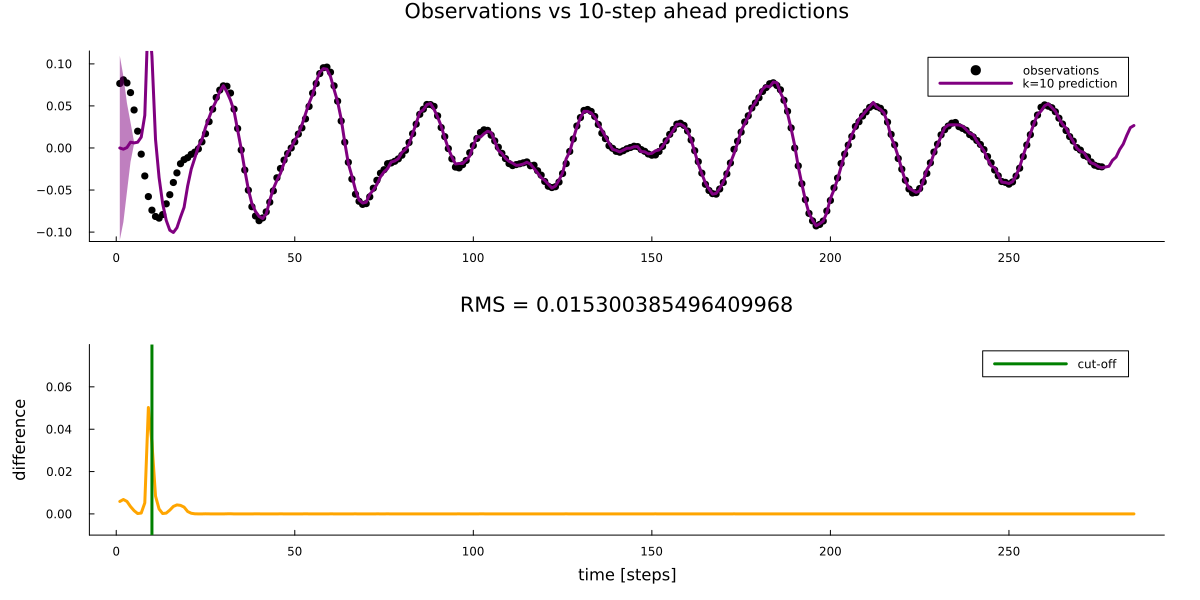

In [89]:
limsb = [minimum(observations)*1.2, maximum(observations)*1.2]
K = 10

residuals = (observations[K:K+(N-T)-1] .- [py[k][1][K] for k in 1:(N-T)]).^2
cutoff = 10
RMS = sqrt(mean((residuals[cutoff:end])))

p1 = plot(title="Observations vs $K-step ahead predictions", ylims=limsb)
scatter!(observations[K:N-T], color="black", label="observations")
plot!([py[k][1][K] for k in 1:(N-T)], ribbon=[py[k][2][K] for k in 1:(N-T)], color="purple", label="k=$K prediction")
p2 = plot(xlabel="time [steps]", ylims=(-0.01, 0.08))
plot!(residuals, title="RMS = $RMS", color="orange", ylabel="difference")
vline!([cutoff], color="green", label="cut-off")
plot(p1,p2,layout=grid(2,1), size=(1200,600),)

## Experiments

In [90]:
# Experiment specification 
N = 100
tsteps = range(0.0, step=Δt, length=N)
T = 10

# System specification
init_state = [0.0, 0.0];

# Agent specification
pτ0 = GammaShapeRate(1e2, 1e0)
pθ0 = MvNormalMeanCovariance(zeros(M), 10diagm(ones(M)))
H = 1
Ly = 3
Lu = 3
M = size(ϕ(zeros(Ly+Lu), degree=H),1);
control_prior = 0.0
num_iters = 10

10

### Expected Free Energy minimization

In [91]:
# Start system
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

SPendulum([0.0, 0.0], -0.0005033726013531494, 0.0, (-50.0, 50.0), 0.1, 2.0, 0.5, 0.2, 0.001)

In [92]:
agent = NARXAgent(qθ[end], qτ[end], 
                  goal_prior=goal, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  thorizon=T,
                  control_prior=control_prior,
                  num_iters=num_iters)

NARXAgent(FactorGraphModel(), Constraints:
  marginals form:
  messages form:
  factorisation:
    q(θ, τ) = q(θ)q(τ)
Options:
  warn = true
, [Inf], MvNormalMeanCovariance(
μ: [-1.1386167967766814e-5, 1.1184456523822721, 0.1981737680434037, -0.6360520767482996, 0.0012897506414830673, -0.000388071592951178, 0.0072930837726872255]
Σ: [3.325909177107549e-6 2.23504555551035e-6 … 1.1444752550931176e-5 -6.04019985256363e-6; 2.23504555551035e-6 0.5829196416034594 … -0.0046282664093726875 -0.0004068219280149813; … ; 1.1444752550931176e-5 -0.0046282664093726875 … 0.015723418998945336 -0.008057181524868302; -6.04019985256363e-6 -0.0004068219280149813 … -0.008057181524868302 0.004226693450314699]
)
, GammaShapeRate{Float64}(a=1142.5, b=1.0141237699265688), NormalMeanVariance{Float64}(μ=3.14, v=0.001), 10, 10, 0.0, 3, 3, 1, 7, [0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

In [134]:
function EFE(agent::NARXAgent, controls)
    "Expected Free Energy"

    μ = mean( agent.qθ)
    Σ = cov(  agent.qθ)
    α = shape(agent.qτ)
    β = rate( agent.qτ)

    ybuffer = agent.ybuffer
    ubuffer = agent.ubuffer
    
    J = 0
    for t in 1:agent.thorizon
        
        # Update control buffer
        ubuffer = backshift(ubuffer, controls[t])
        ϕ_k = ϕ([ybuffer; ubuffer], degree=agent.pol_degree)
        
        # Prediction
        m_y = dot(μ, ϕ_k)
        v_y = ϕ_k'*Σ*ϕ_k + β/α
        
        # Accumulate EFE
        # J += ambiguity(agent, ϕ_k) + risk(agent, Normal(m_y,v_y)) + agent.control_prior*controls[t]^2
        J += mutualinfo(agent, ϕ_k) + risk(agent, m_y,v_y) + agent.control_prior*controls[t]^2
        # J += risk(agent, m_y,v_y) + agent.control_prior*controls[t]^2
        # J += mutualinfo(agent, ϕ_k)
        
        # Update previous 
        ybuffer = backshift(ybuffer, m_y)        
    end
    return J
end

opts = Optim.Options(time_limit=3.0, 
                     allow_f_increases=true, 
                     g_tol=1e-12, 
                     show_every=10,
                     iterations=10_000)

# Objective function
agent.goal = NormalMeanVariance(3.14, 1e3)
J(u) = EFE(agent, u)

# Constrained minimization procedure
results = optimize(J, sys_ulims..., randn(T), Fminbox(LBFGS()), opts, autodiff=:forward)

 * Status: success

 * Candidate solution
    Final objective value:     5.300637e+00

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 4.82e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.41e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.16e-10 ≰ 1.0e-12

 * Work counters
    Seconds run:   2  (vs limit 3)
    Iterations:    3
    f(x) calls:    2084
    ∇f(x) calls:   2084


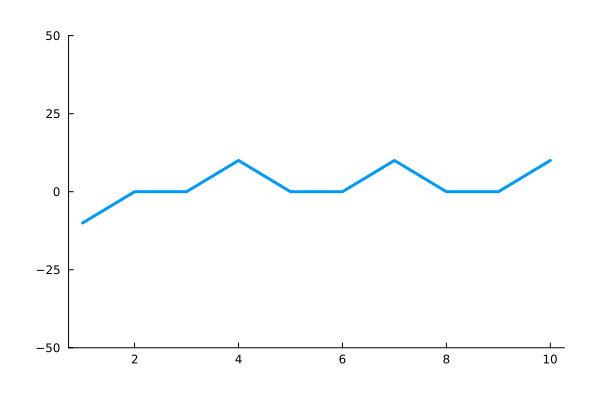

In [138]:
pu_ = Optim.minimizer(results)
plot(pu_, ylims=sys_ulims)

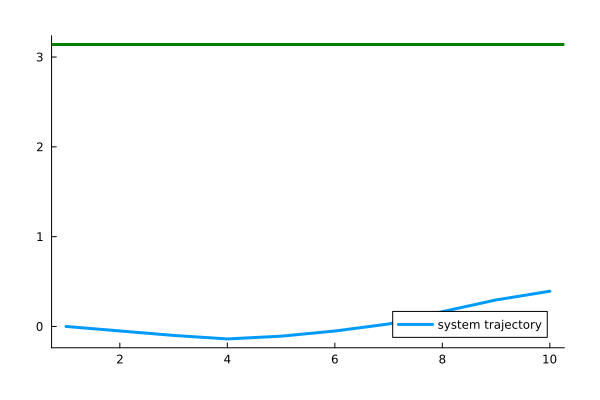

In [139]:
pendulum.state = [0.0, 0.]
sys_trajectory = sim_trajectory(pendulum, pu_)
plot(sys_trajectory[1,:], label="system trajectory")
hline!([mean(goal)], color="green")

In [105]:
# Start system
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

# Start agent
agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  thorizon=T,
                  control_prior=control_prior,
                  num_iters=num_iters)

                  

# Preallocate
y_EFE = zeros(N)
z_EFE = zeros(2,N)
u_EFE = zeros(N+T)
pτ_EFE = [pτ0]
pθ_EFE = [pθ0]
pred_m = zeros(N,T)
pred_v = zeros(N,T)
F_EFE = zeros(num_iters, N)

@showprogress for k in 1:N
    
    # Act upon environment
    step!(pendulum, u_EFE[k])
    z_EFE[:,k] = pendulum.state
    y_EFE[k] = pendulum.sensor
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_EFE[k], u_EFE[k])
    
    F_EFE[:,k] = agent.free_energy
    push!(pθ_EFE, agent.qθ)
    push!(pτ_EFE, agent.qτ)
    
    # Optimal control
    policy = minimizeEFE(agent, control_lims=sys_ulims)
    u_EFE[k+1:k+T] = policy
    
    # Store future predictions
    pred_m[k,:], pred_v[k,:] = predictions(agent, policy, time_horizon=T)
    
end

Progress:   2%|▉                                        |  ETA: 0:04:42

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


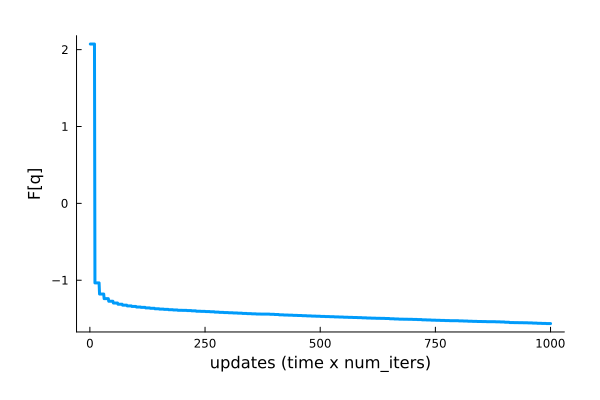

In [106]:
plot(F_EFE[:], xlabel="updates (time x num_iters)", ylabel="F[q]")

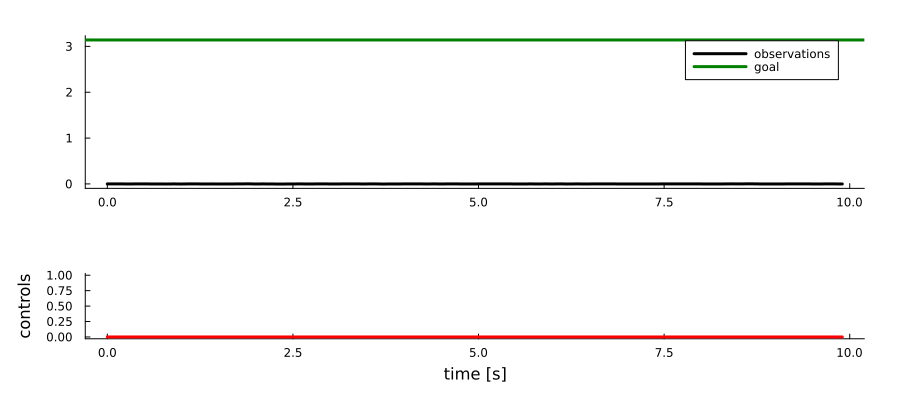

In [107]:
p1 = plot(tsteps, y_EFE, color="black", label="observations")
hline!([mean(goal)], color="green", label="goal")
p4 = plot(tsteps, u_EFE[1:end-T], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [ ]:
savefig("figures/NARX-EFE-1Pendulum-trial.png")

In [ ]:
final_Sθ = det(cov(pθ_EFE[end]))
tSθ = [det(cov(pθ_EFE[k])) for k in 1:N]
plot(tSθ, title="|Σ| = $final_Sθ", yscale=:log10)

In [ ]:
K = 10
sum_vy_k = sum(pred_v[:,K])
plot(pred_v[:,K], title="Sum V[y_t+$K] = $sum_vy_k")

In [ ]:
limsb = [minimum(y_EFE)*1.5, maximum(y_EFE)*1.5]

window = 20

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_EFE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    else
        plot(tsteps[k-window:k], y_EFE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="prediction", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    end
    
end
gif(anim, "figures/NARX-EFE-1Pendulum-planning.gif", fps=24)

### Mean Squared Error minimization

In [ ]:
# Start system
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     Δt=Δt)

In [ ]:
# Initialize beliefs
pτ_MSE = [pτ0]
pθ_MSE = [pθ0]

# Start agent
agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  memory_actions=Lu, 
                  memory_senses=Ly, 
                  pol_degree=H,
                  thorizon=T,
                  control_prior=control_prior,
                  num_iters=num_iters)

# Preallocate
y_MSE = zeros(N)
z_MSE = zeros(2,N)
u_MSE = zeros(N+1)

pred_m = zeros(N,T)
pred_v = zeros(N,T)
F_MSE = zeros(num_iters, N)

@showprogress for k in 1:N
    
    # Act upon environment
    step!(pendulum, u_MSE[k])
    z_MSE[:,k] = pendulum.state
    y_MSE[k] = pendulum.sensor
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_MSE[k], u_MSE[k])
    
    F_MSE[:,k] = agent.free_energy
    push!(pθ_MSE, agent.qθ)
    push!(pτ_MSE, agent.qτ)
    
    # Optimal control
    policy = minimizeMSE(agent, u_lims=u_lims)
    u_MSE[k+1] = policy[1]
    
    # Store future predictions
    pred_m[k,:], pred_v[k,:] = predictions(agent, policy, time_horizon=T)
    
end

In [ ]:
plot(FE_MSE[:], xlabel="updates (time x num_iters)", ylabel="F[q]")

In [ ]:
p1 = plot(tsteps, y_MSE, color="black", label="observations")
hline!([mean(goal)], color="green", label="goal")
p4 = plot(tsteps, u_MSE[1:end-1], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [ ]:
savefig("figures/NARX-MSE-1Pendulum-trial.png")

In [ ]:
final_Sθ = det(cov(pθ[end]))
tSθ = [det(cov(pθ[k])) for k in 1:N]
plot(tSθ, title="|Σ| = $final_Sθ", yscale=:log10)

In [ ]:
K = 10
sum_vy_k = sum(pred_v[:,K])
plot(pred_v[:,K], title="Sum V[y_t+$K] = $sum_vy_k")

In [ ]:
limsb = [minimum(y_)*1.5, maximum(y_)*1.5]

window = 20

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    else
        plot(tsteps[k-window:k], y_[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="prediction", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    end
    
end
gif(anim, "figures/NARX-MSE-1Pendulum-planning.gif", fps=24)